In [30]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
'''
#파이토치 설치_세그멘테이션
!pip install -U segmentation-models-pytorch
'''

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [31]:
#필요 라이브러리 불러오기
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

In [69]:
#데이터 클래스 정의
class ClearGraspDataset(Dataset):
    def __init__(self, image_dir, edge_dir, transform=None):
        self.image_dir = image_dir
        self.edge_dir = edge_dir
        self.transform = transform

        image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]
        edge_files  = [f for f in os.listdir(edge_dir) if f.endswith('.jpg') or f.endswith('.png')]

        #오류 방지 위해 공백 제거한 이름을 기준으로 매칭
        image_map = {f.replace(" ", "").rsplit(".", 1)[0]: f for f in image_files}
        edge_map  = {f.replace(" ", "").rsplit(".", 1)[0]: f for f in edge_files}

        common_keys = sorted(set(image_map.keys()) & set(edge_map.keys()))

        if not common_keys:
            raise ValueError("일치하는 이미지-마스크 쌍이 없습니다.")

        self.image_files = [image_map[k] for k in common_keys]
        self.edge_files  = [edge_map[k] for k in common_keys]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        edge_path = os.path.join(self.edge_dir, self.edge_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        edge = cv2.imread(edge_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, edge=edge)
            image = augmented["image"]
            edge = augmented["edge"]  # 이미 Tensor

        return image, edge.long()

In [70]:
#데이터 셋 및 데이터 로더 구성하기

#학습셋 경로
train_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/train/images"
train_edge_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/train/outlines/outline"

#검증셋 경로
val_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/val/image/images"
val_edge_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/val/outlines/outline"

import albumentations as A
from albumentations.pytorch import ToTensorV2

#데이터 변환
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'edge': 'mask'})

#Dataset 정의
train_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)
val_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)

#DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

'''
#Dataset 정의
train_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)
val_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)

#DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
'''

'\n#Dataset 정의\ntrain_dataset = ClearGraspDataset(train_image_dir, train_edge_dir, transform=transform)\nval_dataset   = ClearGraspDataset(val_image_dir, val_edge_dir, transform=transform)\n\n#DataLoader 정의\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)\nval_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)\n'

In [71]:
#데이터 개수 확인
print(f"Train셋 크기: {len(train_dataset)}개")
print(f"Val셋 크기  : {len(val_dataset)}개")

sample_img, sample_edge = train_dataset[0]
print("이미지 shape:", sample_img.shape)
print("edge shape:", sample_edge.shape)

Train셋 크기: 45454개
Val셋 크기  : 532개
이미지 shape: torch.Size([3, 256, 256])
edge shape: torch.Size([256, 256])


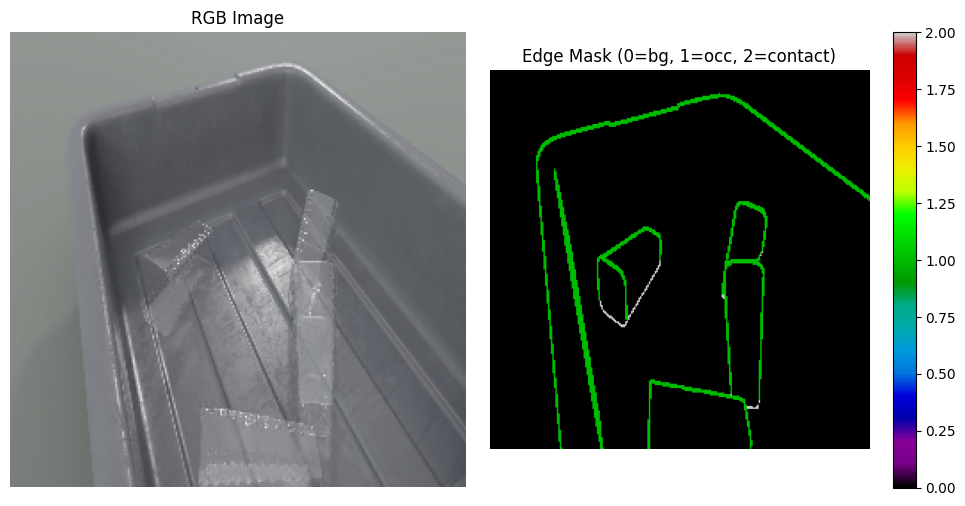

In [72]:
#이미지와 엣지가 잘 매핑됐나 확인
import matplotlib.pyplot as plt

#정규화 해제 함수_없으면 사진이 파랗게 나옴
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

#첫 샘플 가져오기
image_tensor, mask_tensor = train_dataset[0]

#정규화 해제
image_tensor = denormalize(image_tensor)

#Tensor → NumPy로 변환_오류 없애기 위함
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()   # (C, H, W) → (H, W, C)
image_np = np.clip(image_np, 0, 1).astype(np.float32)

mask_np = mask_tensor.cpu().numpy()

#시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap='nipy_spectral', vmin=0, vmax=2)
plt.title("Edge Mask (0=bg, 1=occ, 2=contact)")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

In [73]:
#사전학습된 U-net 모델 로딩
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
).cuda()

In [74]:
#손실함수 및 최적화함수
class_weights = torch.tensor([1.0, 4.0, 5.0]).cuda() #가중치 추가
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [75]:
#학습 루프
def train_model(n_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for imgs, edges in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, edges)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, edges in val_loader:
                imgs, edges = imgs.cuda(), edges.cuda()
                outputs = model(imgs)
                loss = criterion(outputs, edges)
                val_loss += loss.item()

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_cleargrasp_unet.pth")
            print("Best model saved")

In [76]:
#정규화 해제 함수 정의
def visualize_predictions():
    model.eval()
    imgs, edges = next(iter(val_loader))
    imgs, edges = imgs.cuda(), edges.cuda()

    with torch.no_grad():
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)

    #정규화 해제 + torch에서 clamp + numpy로 변환
    imgs = denormalize(imgs)
    imgs = imgs.clamp(0, 1).cpu()
    imgs = imgs.permute(0, 2, 3, 1).numpy()
    imgs = np.clip(imgs, 0, 1).astype(np.float32)  # float32로 고정

    edges = edges.cpu().numpy()
    preds = preds.cpu().numpy()

    for i in range(min(3, len(imgs))):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        axs[0].imshow(imgs[i])
        axs[0].set_title("RGB Image")

        axs[1].imshow(edges[i], cmap='nipy_spectral', vmin=0, vmax=2)
        axs[1].set_title("Ground Truth")

        axs[2].imshow(preds[i], cmap='nipy_spectral', vmin=0, vmax=2)
        axs[2].set_title("Prediction")

        for ax in axs:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

Epoch 1/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 1 | Train Loss: 0.2254 | Val Loss: 0.1153
Best model saved


Epoch 2/30: 100%|██████████| 1421/1421 [11:57<00:00,  1.98it/s]


Epoch 2 | Train Loss: 0.1044 | Val Loss: 0.1013
Best model saved


Epoch 3/30: 100%|██████████| 1421/1421 [11:56<00:00,  1.98it/s]


Epoch 3 | Train Loss: 0.0871 | Val Loss: 0.1053


Epoch 4/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 4 | Train Loss: 0.0791 | Val Loss: 0.1048


Epoch 5/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.98it/s]


Epoch 5 | Train Loss: 0.0721 | Val Loss: 0.0825
Best model saved


Epoch 6/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.97it/s]


Epoch 6 | Train Loss: 0.0678 | Val Loss: 0.0854


Epoch 7/30: 100%|██████████| 1421/1421 [11:56<00:00,  1.98it/s]


Epoch 7 | Train Loss: 0.0649 | Val Loss: 0.0779
Best model saved


Epoch 8/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.98it/s]


Epoch 8 | Train Loss: 0.0599 | Val Loss: 0.0983


Epoch 9/30: 100%|██████████| 1421/1421 [11:56<00:00,  1.98it/s]


Epoch 9 | Train Loss: 0.0580 | Val Loss: 0.0802


Epoch 10/30: 100%|██████████| 1421/1421 [12:00<00:00,  1.97it/s]


Epoch 10 | Train Loss: 0.0549 | Val Loss: 0.0716
Best model saved


Epoch 11/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 11 | Train Loss: 0.0530 | Val Loss: 0.1155


Epoch 12/30: 100%|██████████| 1421/1421 [12:00<00:00,  1.97it/s]


Epoch 12 | Train Loss: 0.0517 | Val Loss: 0.0973


Epoch 13/30: 100%|██████████| 1421/1421 [11:56<00:00,  1.98it/s]


Epoch 13 | Train Loss: 0.0497 | Val Loss: 0.0864


Epoch 14/30: 100%|██████████| 1421/1421 [12:01<00:00,  1.97it/s]


Epoch 14 | Train Loss: 0.0464 | Val Loss: 0.0818


Epoch 15/30: 100%|██████████| 1421/1421 [12:16<00:00,  1.93it/s]


Epoch 15 | Train Loss: 0.0494 | Val Loss: 0.0826


Epoch 16/30: 100%|██████████| 1421/1421 [12:02<00:00,  1.97it/s]


Epoch 16 | Train Loss: 0.0442 | Val Loss: 0.0805


Epoch 17/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.98it/s]


Epoch 17 | Train Loss: 0.0423 | Val Loss: 0.0844


Epoch 18/30: 100%|██████████| 1421/1421 [12:02<00:00,  1.97it/s]


Epoch 18 | Train Loss: 0.0434 | Val Loss: 0.0811


Epoch 19/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.97it/s]


Epoch 19 | Train Loss: 0.0406 | Val Loss: 0.1397


Epoch 20/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 20 | Train Loss: 0.0394 | Val Loss: 0.0989


Epoch 21/30: 100%|██████████| 1421/1421 [12:02<00:00,  1.97it/s]


Epoch 21 | Train Loss: 0.0382 | Val Loss: 0.0932


Epoch 22/30: 100%|██████████| 1421/1421 [11:57<00:00,  1.98it/s]


Epoch 22 | Train Loss: 0.0385 | Val Loss: 0.1157


Epoch 23/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 23 | Train Loss: 0.0364 | Val Loss: 0.1123


Epoch 24/30: 100%|██████████| 1421/1421 [11:55<00:00,  1.99it/s]


Epoch 24 | Train Loss: 0.0349 | Val Loss: 0.0779


Epoch 25/30: 100%|██████████| 1421/1421 [11:59<00:00,  1.97it/s]


Epoch 25 | Train Loss: 0.0345 | Val Loss: 0.0950


Epoch 26/30: 100%|██████████| 1421/1421 [11:57<00:00,  1.98it/s]


Epoch 26 | Train Loss: 0.0346 | Val Loss: 0.1144


Epoch 27/30: 100%|██████████| 1421/1421 [11:58<00:00,  1.98it/s]


Epoch 27 | Train Loss: 0.0332 | Val Loss: 0.1163


Epoch 28/30: 100%|██████████| 1421/1421 [12:01<00:00,  1.97it/s]


Epoch 28 | Train Loss: 0.0317 | Val Loss: 0.1188


Epoch 29/30: 100%|██████████| 1421/1421 [12:01<00:00,  1.97it/s]


Epoch 29 | Train Loss: 0.0315 | Val Loss: 0.1120


Epoch 30/30: 100%|██████████| 1421/1421 [12:01<00:00,  1.97it/s]


Epoch 30 | Train Loss: 0.0301 | Val Loss: 0.1506


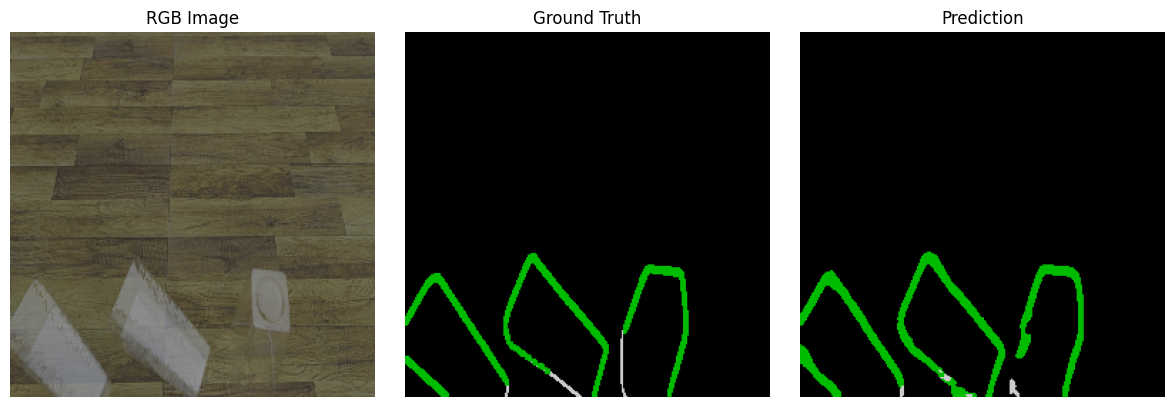

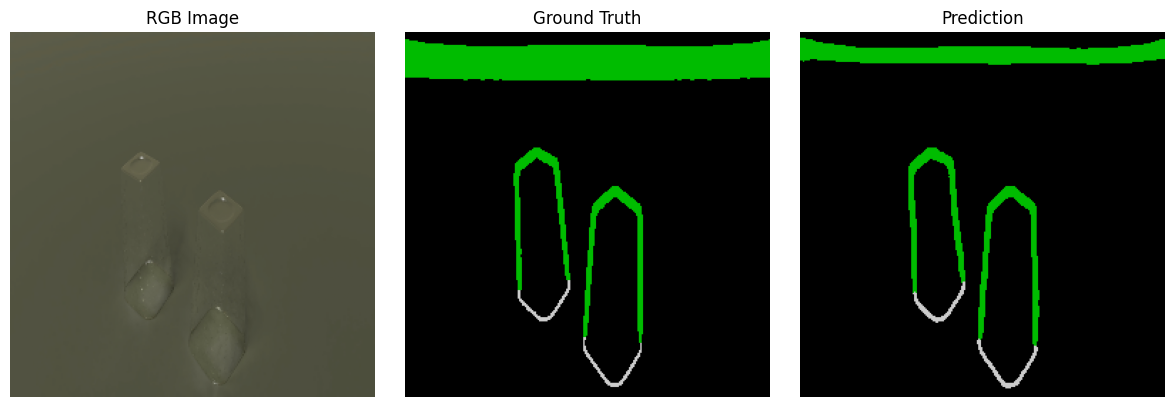

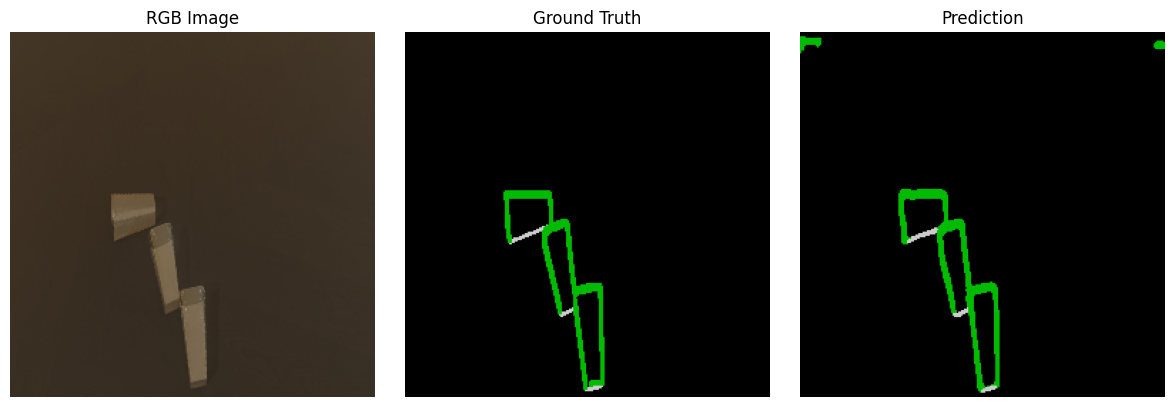

In [77]:
#실행
if __name__ == '__main__':
    train_model(n_epochs=30)
    visualize_predictions()

In [26]:
'''
#최초 1회만 실행 - 이미 드라이브에 파일 만들어져 있음!
#외곽선 이미지와 RGB 이미지 매칭시키기
import os
import shutil

# 원본 폴더
test_img_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/images"
test_edge_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/outlines/outline"

# 저장할 폴더
matched_img_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/image"
matched_edge_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/outline"
os.makedirs(matched_img_dir, exist_ok=True)
os.makedirs(matched_edge_dir, exist_ok=True)

# 파일명에서 번호만 추출하는 함수
import re
def extract_id(filename):
    match = re.search(r'\((\d+)\)', filename)
    return match.group(1) if match else None

# RGB 이미지와 엣지 이름 목록 불러오기
img_files = [f for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]
edge_files = [f for f in os.listdir(test_edge_dir) if f.endswith(('.jpg', '.png'))]

# ID 매핑
img_dict = {extract_id(f): f for f in img_files}
edge_dict = {extract_id(f): f for f in edge_files}

# 공통 ID 추출
common_ids = set(img_dict.keys()).intersection(set(edge_dict.keys()))

print(f"매칭된 샘플 수: {len(common_ids)}")

# 매칭된 파일 복사
for id_ in common_ids:
    src_img = os.path.join(test_img_dir, img_dict[id_])
    src_edge = os.path.join(test_edge_dir, edge_dict[id_])

    dst_img = os.path.join(matched_img_dir, img_dict[id_])
    dst_edge = os.path.join(matched_edge_dir, edge_dict[id_])

    shutil.copy(src_img, dst_img)
    shutil.copy(src_edge, dst_edge)
    '''

✅ 매칭된 샘플 수: 109


In [78]:
#테스트셋 정의
test_dataset = ClearGraspDataset(
    image_dir="/content/drive/MyDrive/Cleargrasp_Dataset/test/image",
    edge_dir="/content/drive/MyDrive/Cleargrasp_Dataset/test/outline",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [79]:
#학습된 best 모델 로드
model.load_state_dict(torch.load("best_cleargrasp_unet.pth"))
model.eval()

from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_classwise_accuracy(loader, num_classes=3):
    y_true_all, y_pred_all = [], []

    with torch.no_grad():
        for imgs, edges in tqdm(loader, desc="Testing"):
            imgs, edges = imgs.cuda(), edges.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            y_true_all.extend(edges.view(-1).cpu().numpy())
            y_pred_all.extend(preds.view(-1).cpu().numpy())

    cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))
    acc_per_class = cm.diagonal() / cm.sum(axis=1)

    for i, acc in enumerate(acc_per_class):
        print(f"Class {i} Accuracy: {acc:.4f}")

    pixel_acc = np.mean(np.array(y_true_all) == np.array(y_pred_all))
    print(f"🎯 Total Pixel Accuracy: {pixel_acc * 100:.2f}%")


calculate_classwise_accuracy(test_loader)

Testing: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

Class 0 Accuracy: 0.9796
Class 1 Accuracy: 0.7509
Class 2 Accuracy: 0.5304
🎯 Total Pixel Accuracy: 96.88%
